In [90]:
import numpy as np
import pandas as pd
from numpy import mean, std, log, sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
import statsmodels.api as sm

%load_ext rpy2.ipython
%R -o weekly library(ISLR); weekly = Weekly;

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
def c_matrix(y_true, y_pred, labels, print_results=True):
    """Formatted Confusion Matrix"""
    cmat = pd.DataFrame(confusion_matrix(y_true, y_pred, labels), columns=labels)
    true_vals = cmat.apply(sum, 0).values
    pred_vals = cmat.apply(sum, 1).values
    cmat.loc[len(cmat)] = true_vals
    cmat["Predicted"] = np.append(pred_vals, sum(pred_vals))
    cmat.index = ["Up", "Down", "True"]
    
    if print_results:
        specificity = cmat.ix["Up", "Up"] / cmat.ix["True", "Up"]
        sensitivity = cmat.ix["Down", "Down"] / cmat.ix["True", "Down"]
        overall_error_rate = 1 - (y_true == y_pred).mean()
        print("O.E.R.: {:>11.2%}".format(overall_error_rate))
        print("Specificity: {:>4.2%}".format(specificity))
        print("Sensitivity: {:>4.2%}".format(sensitivity))
        
    return cmat

# 1: Weekly Dataset

**a) Produce some numerical and graphical summaries of the data. Do there appear to be any patterns?**

In [2]:
weekly.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000


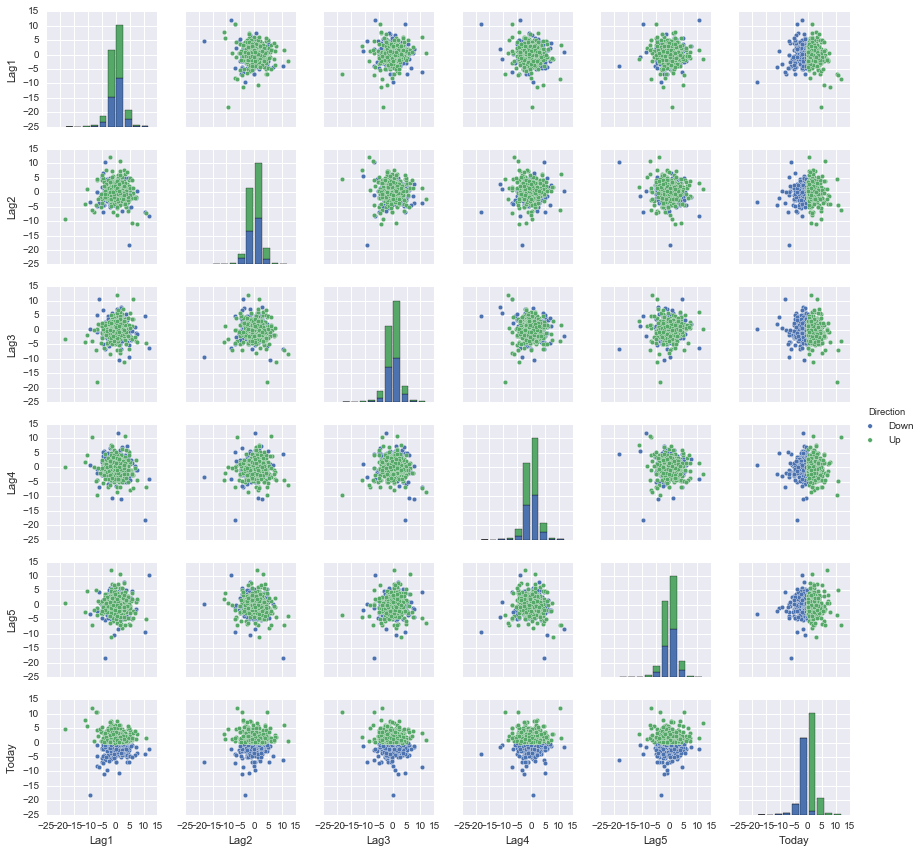

In [95]:
sns.pairplot(weekly.drop(["Volume", "Year"], 1), hue="Direction", size=2)
plt.show()

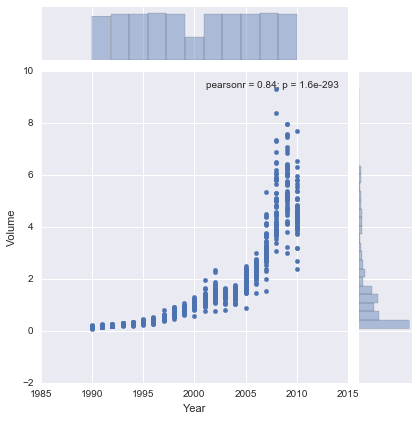

In [4]:
sns.jointplot(x="Year", y="Volume", data=weekly)
plt.show()

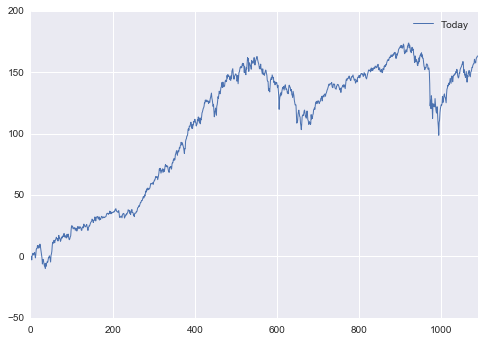

In [5]:
weekly.Today.cumsum().plot(linewidth=1)
plt.legend()
plt.show()

****
**b) Use the full dataset to perform a logisitic regression with `Direction` as the response and the five `Lag`s plus `Volume` as predictor. Do any of the predictors appear to be statistically signiﬁcant?**

In [168]:
predict = [1 if x == "Up" else 0 for x in weekly.Direction]
predictor = weekly.drop(["Direction", "Today"], 1)

log_reg = sm.GLM(predict, predictor, family=sm.families.Binomial()).fit()
print(log_reg.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1089
Model:                            GLM   Df Residuals:                     1082
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -743.18
Date:                Thu, 08 Sep 2016   Deviance:                       1486.4
Time:                        10:40:37   Pearson chi2:                 1.09e+03
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Year           0.0001   4.31e-05      3.105      0.002      4.93e-05     0.000
Lag1          -0.0413      0.026     -1.563      0.1

Among all of the used variables, only `Year` and `Lag2` appear to be statistically significant.

****
**c) Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.**

In [169]:
predicted = ["Up" if x > 0.5 else "Down" for x in log_reg.fittedvalues]
c_matrix(weekly.Direction, predicted, ["Up", "Down"])

O.E.R.:      43.89%
Specificity: 56.43%
Sensitivity: 52.94%


,Up,Down,Predicted
Up,557,48,605
Down,430,54,484
True,987,102,1089


The logistic regression is correctly identifying 56% of the Up Moves and 53% of the down moves. Further analysis could show whether the 56% up move is enough to offset the 47% not-predicted down moves and have gains using this model. Overall, the model is predicting 56% of the total moves correctly.

****
**d) Now ﬁt the logistic regression model using a training data period from 1990 to 2008, with Lag2 as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data**

In [170]:
# Training the model
weekly_lag2 = weekly[["Lag2", "Direction"]][weekly.Year <= 2008]
predict = [1 if x=="Up" else 0 for x in weekly_lag2.Direction]
predictor = weekly_lag2.Lag2

log_reg = sm.GLM(predict, predictor, family=sm.families.Binomial()).fit()
print(log_reg.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  985
Model:                            GLM   Df Residuals:                      984
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -680.29
Date:                Thu, 08 Sep 2016   Deviance:                       1360.6
Time:                        10:40:41   Pearson chi2:                     985.
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Lag2           0.0629      0.029      2.192      0.028         0.007     0.119


In [171]:
year_map = weekly.Year > 2008
y_hat = log_reg.predict(weekly.Lag2[year_map])
y_hat = ["Down" if x < 0.5 else "Up" for x in y_hat]
y_true = weekly.Direction[year_map].values

In [172]:
lr_cm = c_matrix(y_true, y_hat, ["Up", "Down"]); lr_cm

O.E.R.:      45.19%
Specificity: 61.67%
Sensitivity: 45.45%


,Up,Down,Predicted
Up,37,24,61
Down,23,20,43
True,60,44,104


****
**e) Repeat *d)* using LDA**

In [173]:
train_lda = weekly[["Lag2", "Direction"]][weekly.Year <= 2008]
test_lda = weekly[["Lag2", "Direction"]][weekly.Year > 2008]

# Training the model
ups = train_lda.Lag2[train_lda.Direction == "Up"]
downs = train_lda.Lag2[train_lda.Direction == "Down"]
pi_up = len(ups) / (len(ups) + len(downs))
pi_down = len(downs) / (len(ups) + len(downs))
sigma = train_lda.Lag2.std(ddof=1)
mu_up = mean(ups)
mu_down = mean(downs)

For **LDA**, the discrimant is
$$
    \delta_k = x \frac{\hat{\mu}_k}{\hat{\sigma}^2} - \frac{\hat{\mu}_k^2}{2\hat{\sigma}^2} + \log\pi_k
$$

In [174]:
# Predicting direction
delta_k = lambda x, mu, sigma, pi: x * mu / (sigma**2) - mu ** 2 / (2 * sigma ** 2) + log(pi)
test_lda["delta_up"] = test_lda.Lag2.apply(delta_k, args=(mu_up, sigma, pi_up))
test_lda["delta_down"] = test_lda.Lag2.apply(delta_k, args=(mu_down, sigma, pi_down))
test_lda["Dir_Pred"] = ["Up" if dup > ddown else "Down" for (dup, ddown) in test_lda[["delta_up", "delta_down"]].values]
test_lda[["Direction", "Dir_Pred"]].head(10)

,Direction,Dir_Pred
986,Down,Up
987,Down,Up
988,Down,Down
989,Down,Down
990,Up,Up
991,Down,Up
992,Down,Up
993,Down,Down
994,Down,Down
995,Up,Down


In [175]:
lda_cm = c_matrix(y_true=test_lda["Direction"].values,
         y_pred=test_lda["Dir_Pred"].values,
         labels=["Up", "Down"]); lda_cm

O.E.R.:      37.50%
Specificity: 62.22%
Sensitivity: 64.29%


,Up,Down,Predicted
Up,56,5,61
Down,34,9,43
True,90,14,104


We can estimate where does the LDA Bayes Decision Boundary happen. In this case:

$$
    X_{L.D.A.} = \frac{\frac{1}{2}(\hat{\mu}_u^2 - \hat{\mu}_d^2) + \hat{\sigma}^2\log{\frac{\pi_u}{\pi_d}}}{\hat{\mu}_u - \hat{\mu}_d}
$$

In [176]:
x_range = np.linspace(-4, -2.5, 10000)
dup_vector = np.apply_along_axis(lambda x: delta_k(x, mu_up, sigma, pi_up), 0, x_range)
ddown_vector = np.apply_along_axis(lambda x: delta_k(x, mu_down, sigma, pi_down), 0, x_range)

# Numerical Estimation
for ix, (up, down) in enumerate(zip(dup_vector, ddown_vector)):
    if abs(up-down) < 1e-5:
        bayes_decision_boundary = x_range[ix]
        print(bayes_decision_boundary)
        break
        
# Theoretical Estimation
((mu_up**2 - mu_down**2) / 2 + sigma**2 * log(pi_down / pi_up)) / (mu_up - mu_down)

-3.53825382538


-3.5381757868575869

In [177]:
test_lda[test_lda["Lag2"] <= -2][:10]

,Lag2,Direction,delta_up,delta_down,Dir_Pred
988,-4.448,Down,-0.825209,-0.772894,Down
989,-4.518,Down,-0.828749,-0.772409,Down
990,-2.137,Up,-0.708343,-0.788910,Up
993,-4.808,Down,-0.843414,-0.770399,Down
994,-6.868,Down,-0.947587,-0.756122,Down
995,-4.540,Up,-0.829861,-0.772256,Down
996,-7.035,Up,-0.956032,-0.754965,Down
1006,-4.988,Up,-0.852516,-0.769151,Down
1011,-2.640,Down,-0.733779,-0.785424,Up
1013,-2.446,Up,-0.723969,-0.786769,Up


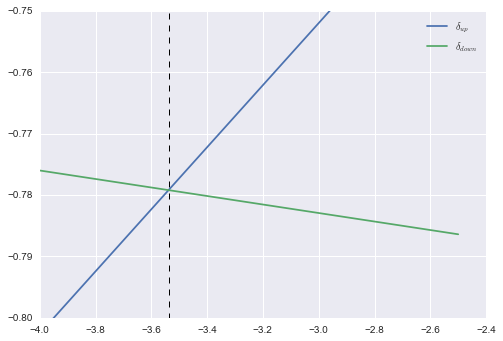

In [178]:
plt.plot(x_range, dup_vector, label=r"$\delta_{up}$")
plt.plot(x_range, ddown_vector, label=r"$\delta_{down}$")
plt.vlines(bayes_decision_boundary, -0.81, -0.70, linestyle="dashed", linewidth=1)
plt.ylim(-0.80, -0.75)
plt.legend(loc="best")
plt.show()

From the graph above it is visually clear that we would we predict `Up` whenever $\delta_{\text{down}} < \delta_{\text{up}}$. We can also visualize the approximate location of the *Bayes Decision Boundary*, which happens at around $-3.54$

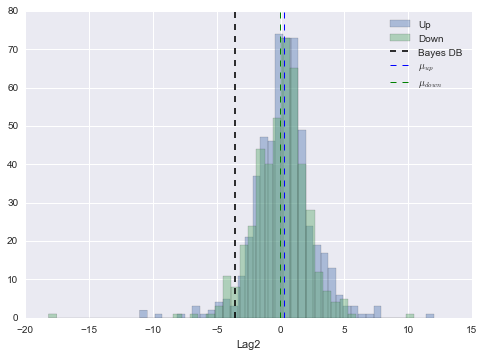

In [179]:
sns.distplot(ups, kde=False, label="Up")
sns.distplot(downs, kde=False, label="Down")
plt.vlines(bayes_decision_boundary, 0, 80, linestyles="dashed", label="Bayes DB", linewidth=1.6)
plt.vlines(mu_up, 0, 80, linestyles="dashed", label=r"$\mu_{up}$", linewidth=1, colors="blue")
plt.vlines(mu_down, 0, 80, linestyles="dashed", label=r"$\mu_{down}$", linewidth=1, colors="green")
plt.legend(loc="best")

plt.show()

****
**f) Repeat *d)* using QDA**

In [180]:
train_qda = weekly[["Lag2", "Direction"]][weekly.Year <= 2008]
test_qda = weekly[["Lag2", "Direction"]][weekly.Year > 2008]

# Training the model
ups = train_qda.Lag2[train_qda.Direction == "Up"]
downs = train_qda.Lag2[train_qda.Direction == "Down"]

pi_up = len(ups) / (len(ups) + len(downs))
pi_down = len(downs) / (len(ups) + len(downs))

mu_up = mean(ups)
mu_down = mean(downs)

sigma_up = std(ups, ddof=1)
sigma_down = std(downs, ddof=1)

For **QDA**, the discriminant is:
$$
    \delta_k(x) = \frac{1}{\hat{\sigma}^2_k}(x - \hat{\mu}_k)^2 + \log\frac{\pi_k}{\sigma_k}
$$

In [181]:
delta_k = lambda x, mu, sigma, pi: (x - mu) ** 2 / sigma ** 2 + log(pi/sigma)
test_qda["delta_up"] = test_qda.Lag2.apply(delta_k, args=(mu_up, sigma_up, pi_up))
test_qda["delta_down"] = test_qda.Lag2.apply(delta_k, args=(mu_down, sigma_down, pi_down))
test_qda["Dir_Pred"] = ["Up" if up > down else "Down" for (up, down) in test_qda[["delta_up", "delta_down"]].values]

In [182]:
qda_cm = c_matrix(y_true=test_qda.Direction,
         y_pred=test_qda.Dir_Pred,
         labels=["Up","Down"]); qda_cm

O.E.R.:      47.12%
Specificity: 60.00%
Sensitivity: 43.18%


,Up,Down,Predicted
Up,36,25,61
Down,24,19,43
True,60,44,104


The QDA Bayes Decision Boundary happens at:
    $$
        X_{Q.D.A} = \frac{\left[\frac{\mu_u}{\sigma_u^2} - \frac{\mu_d}{\sigma_d^2}\right] + \sqrt{\left[\frac{\mu_u}{\sigma_u^2} - \frac{\mu_d}{\sigma_d^2}\right]^2 + \left[\log\frac{\pi_d\sigma_u}{\pi_u\sigma_d} + \frac{\mu_d}{\sigma_d^2} - \frac{\mu_u}{\sigma_u^2}\right]\left[\frac{1}{\sigma_u^2} - \frac{1}{\sigma_d^2}\right]}}{\left[\frac{1}{\sigma_u^2} - \frac{1}{\sigma_d^2}\right]}
    $$

In [183]:
x_range = np.linspace(-10, 6, 100000)

dup_vector = np.apply_along_axis(lambda x: delta_k(x, mu_up, sigma_up, pi_up), 0, x_range)
ddown_vector = np.apply_along_axis(lambda x: delta_k(x, mu_down, sigma_down, pi_down), 0, x_range)

# Numerical Estimation
for ix, (up, down) in enumerate(zip(dup_vector, ddown_vector)):
    if abs(up-down) <= 1e-5:
        print(x_range[ix])
print()

# Theoretical Estimation
A = (mu_up / sigma_up**2 - mu_down / sigma_down**2) 
C = (1/sigma_up**2 - 1/sigma_down**2)
B = sqrt(A**2 + (log((pi_down*sigma_up)/(pi_up*sigma_down)) + mu_down**2 / sigma_down**2 - mu_up**2 / sigma_up**2)*C)
qda_bd1 = (A + B)/C
qda_bd2 = (A - B)/C
print(qda_bd1)
print(qda_bd2)

-6.68604686047
1.23979239792

-6.68610486678
1.2397325755


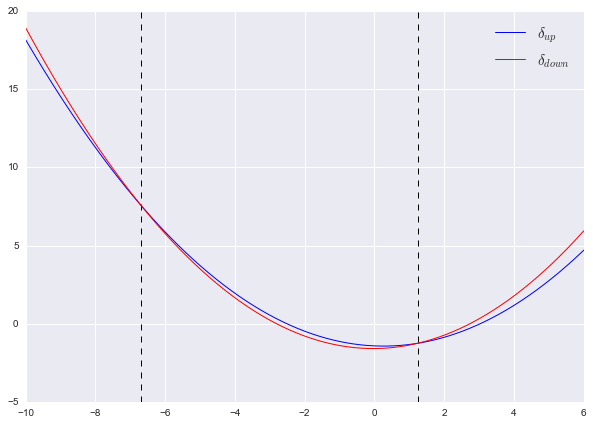

In [184]:
plt.figure(figsize=(10,7))

plt.plot(x_range, dup_vector, label=r"$\delta_{up}$", linewidth=1, color="blue")
plt.plot(x_range, ddown_vector, label=r"$\delta_{down}$", linewidth=1, color="red")
plt.vlines(qda_bd1, -5, 20, linestyles="dashed", linewidth=1)
plt.vlines(qda_bd2, -5, 20, linestyles="dashed", linewidth=1)
plt.legend(loc="best", fontsize=15)
plt.show()

In [185]:
test_qda.sample(10)

,Lag2,Direction,delta_up,delta_down,Dir_Pred
1043,-1.639,Up,-0.762463,-1.060468,Up
1029,-0.743,Up,-1.246726,-1.488415,Up
1028,1.511,Down,-1.142952,-1.097344,Down
1064,-3.646,Up,1.407090,1.102442,Up
1051,0.577,Up,-1.415508,-1.514236,Up
1003,-0.388,Up,-1.355903,-1.566171,Up
1068,3.548,Up,0.578311,1.062835,Down
1076,1.446,Down,-1.172437,-1.138032,Down
1072,-0.700,Up,-1.262448,-1.500606,Up
1047,-0.422,Up,-1.347479,-1.560980,Up


From `LDA` v.s. `QDA`, `QDA` perfomed worst than `LDA`.

Given the implicit assumption in `QDA` that $\sigma_k$ is different for each class, we expect $\sigma_k$ from both `Lag2` when up and `Lag2` when down to be approximatly equal. If so, that might explain why is `QDA` underperforming.

In [186]:
print("sigma_up =", dup_vector.std())
print("sigma_down =", ddown_vector.std())

sigma_up = 5.26670010213
sigma_down = 5.44294293206


****
**g) Repeat using KNN when $K=1$**

In [252]:
#KNN will predict the class given by the closes point as measured by the euclidean distance
train_knn = weekly[["Lag2", "Direction"]][weekly.Year <= 2008]
test_knn  = weekly[["Lag2", "Direction"]][weekly.Year > 2008]

x_down = train_knn[train_knn.Direction == "Down"].Lag2
y_down = np.repeat(-1, len(train_knn[train_knn.Direction == "Down"]))

x_up = train_knn[train_knn.Direction == "Up"].Lag2
y_up = np.repeat(1, len(train_knn[train_knn.Direction == "Up"]))

In [253]:
# For each value in the test_knn, we get the Direction of the closest train_knn to that point,
# that will be our predicted value
predictions = []
for ix in test_knn.index:
    index = abs(test_knn.Lag2[ix] - train_knn.Lag2).idxmin()
    pred = train_knn.Direction[index]
    predictions.append(pred)
    
test_knn["Dir_Pred"] = predictions

In [193]:
knn_cm = c_matrix(test_knn.Direction.values, predictions, ("Up", "Down"))
knn_cm

O.E.R.:      50.00%
Specificity: 58.82%
Sensitivity: 41.51%


,Up,Down,Predicted
Up,30,31,61
Down,21,22,43
True,51,53,104


****
**h) Which of these methods appears to provide the best results on this data?**

In [37]:
def compute_values(con_mat):
    ovall = (con_mat.ix["Up","Up"] + con_mat.ix["Down","Down"])/con_mat.ix["True","Predicted"]
    specificity = con_mat.ix["Up","Up"] / con_mat.ix["True","Up"]
    sensitivity = con_mat.ix["Down","Down"] / con_mat.ix["True","Down"]
    print("Correct (%): {:>9.3f}".format(ovall))
    print("Specificity (%): {:.3f}".format(specificity))
    print("Sensitivity (%): {:.3f}".format(sensitivity))
    return con_mat

def pred_plot(test, train, title):
    # Get x, y of'Lag2' from values predicted as down
    x_down = train[train.Direction == "Down"].Lag2
    y_down = np.repeat(-1, len(train[train.Direction == "Down"]))

    x_up = train[train.Direction == "Up"].Lag2
    y_up = np.repeat(1, len(train[train.Direction == "Up"]))

    plt.figure(figsize=(16,5))

    plt.scatter(x_up, y_up, s=20, color="#51A39D", alpha=0.5, label="Up")
    plt.scatter(x_down, y_down, s=20, color = "#B7695C", alpha=0.5, label="Down")

    for (x, true, pred) in test[["Lag2","Direction","Dir_Pred"]].values:
        color = "#51A39D" if pred == "Up" else "#B7695C"
        mrkr = "^" if pred == "Up" else "v"
        y_pos = 1.1 if true=="Up" else -1.1
        plt.scatter(x, y_pos, s=25, color = color, alpha=0.7, marker=mrkr)

    plt.yticks((-1,1), ("Down", "Up"))
    plt.legend(loc=3)
    plt.title(title)
    plt.show()

In [262]:
compute_values(lr_cm)

Correct (%):     0.548
Specificity (%): 0.617
Sensitivity (%): 0.455


,Up,Down,Predicted
Up,37,24,61
Down,23,20,43
True,60,44,104


Correct (%):     0.625
Specificity (%): 0.622
Sensitivity (%): 0.643


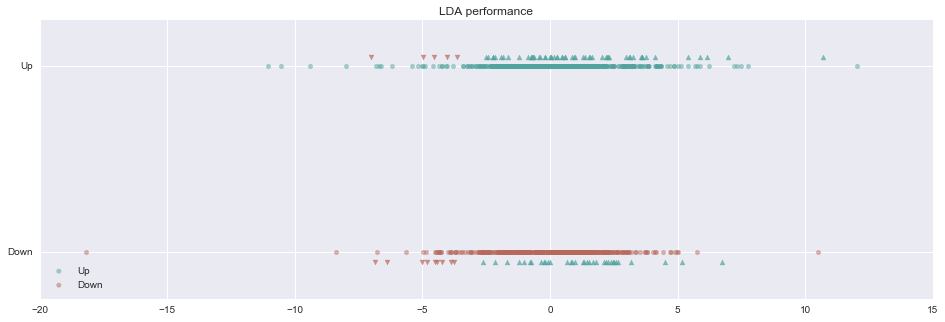

In [263]:
compute_values(lda_cm)
pred_plot(test_lda, train_lda, "LDA performance")

Correct (%):     0.529
Specificity (%): 0.600
Sensitivity (%): 0.432


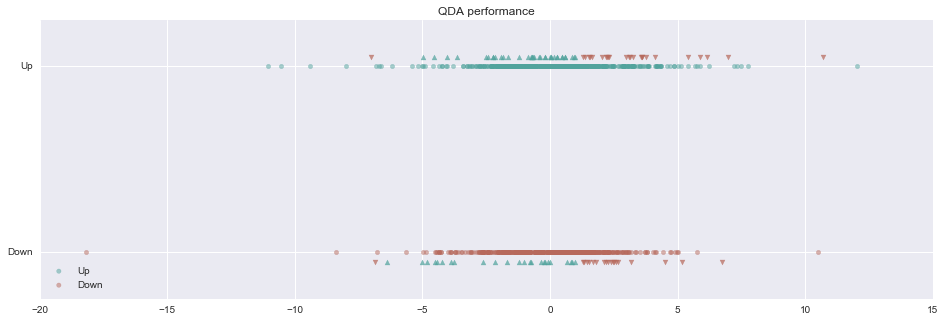

In [264]:
compute_values(qda_cm)
pred_plot(test_qda, train_qda, "QDA performance")

Correct (%):     0.500
Specificity (%): 0.588
Sensitivity (%): 0.415


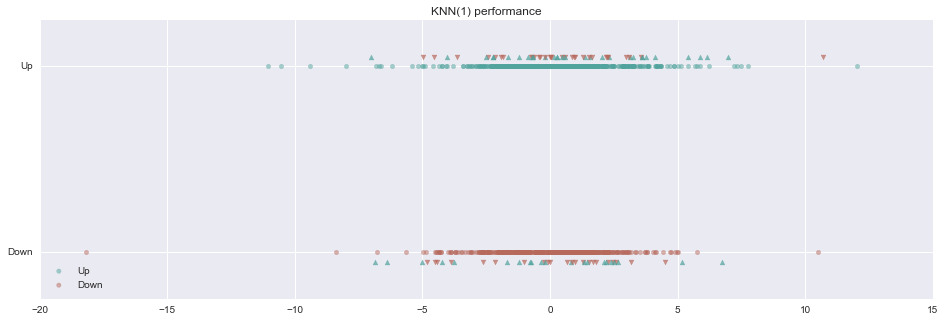

In [266]:
compute_values(knn_cm)
pred_plot(test_knn, train_knn, "KNN(1) performance")

`LDA` perfomed best for total overall rate, specificity and sensitivity

****
**I) Experiment with diﬀerent combinations of predictors, including possible transformations and interactions, for each of the methods. Report the variables, method, and associated confusion matrix that appears to provide the best results on the held out data. Note that you should also experiment with values for K in the KNN classiﬁer.**

We will start by creating a global `test` and `training` dataset

**Comparing KNN Perfomance on varying *n*:**


In [107]:
from sklearn.neighbors import KNeighborsClassifier

def train_knn(n):
    data_train = weekly[["Lag2", "Direction"]][weekly.Year <= 2008]
    data_test = weekly[["Lag2", "Direction"]][weekly.Year > 2008]

    # Changing values of market direction. 
    # "Down" => 0 // "Up" => 1
    data_train.Direction = [0 if drc == "Down" else 1 for drc in data_train.Direction]

    knn = KNeighborsClassifier(n_neighbors=n)
    x_train = [[v] for v in data_train.Lag2.values]
    x_test = [[v] for v in data_test.Lag2.values]
    knn.fit(x_train, data_train.Direction)

    # Reverting values of market direction. 
    # 0 => "Down" // 1 => "Up"
    data_train.Direction = ["Down" if drc == 0 else "Up" for drc in data_train.Direction]
    preds = knn.predict(x_test)


    data_test["Dir_Pred"] = ["Up" if pred == 1 else "Down" for pred in preds]
    
    return {"test":data_test
            "train": data_train} 

In [122]:
oer_vector = []
for k in range(1,101):
    knn_mod = train_knn(k)
    # Overall error rate
    oer = 1 - (knn_mod["test"].Direction == knn_mod["test"].Dir_Pred).mean()
    oer_vector.append(oer)

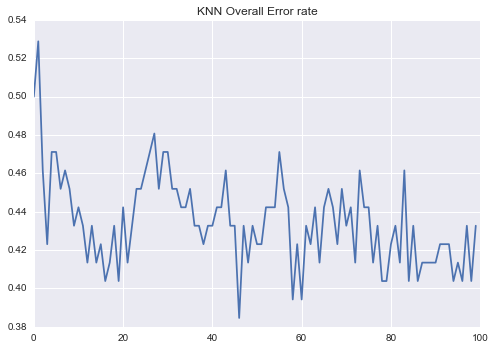

In [123]:
plt.plot(oer_vector)
plt.title("KNN Overall Error Rate")
plt.show()

# 2: Auto Dataset

In [2]:
%R -o auto library(ISLR); auto = Auto;

**a) Create a binary variable, ``mpg01``, that contains a 1 if ``mpg`` contains a value above its median, and a 0 if ``mpg`` contains a value below its median.**

In [3]:
auto["mpg01"] = [1 if mpg > np.median(auto.mpg) else 0 for mpg in auto.mpg]

**b) Explore the data graphically in order to investigate the association between mpg01 and the other features. Which of the other features seem most likely to be useful in predicting mpg01? Scatterplots and boxplots may be useful tools to answer this question. Describe your ﬁndings.**

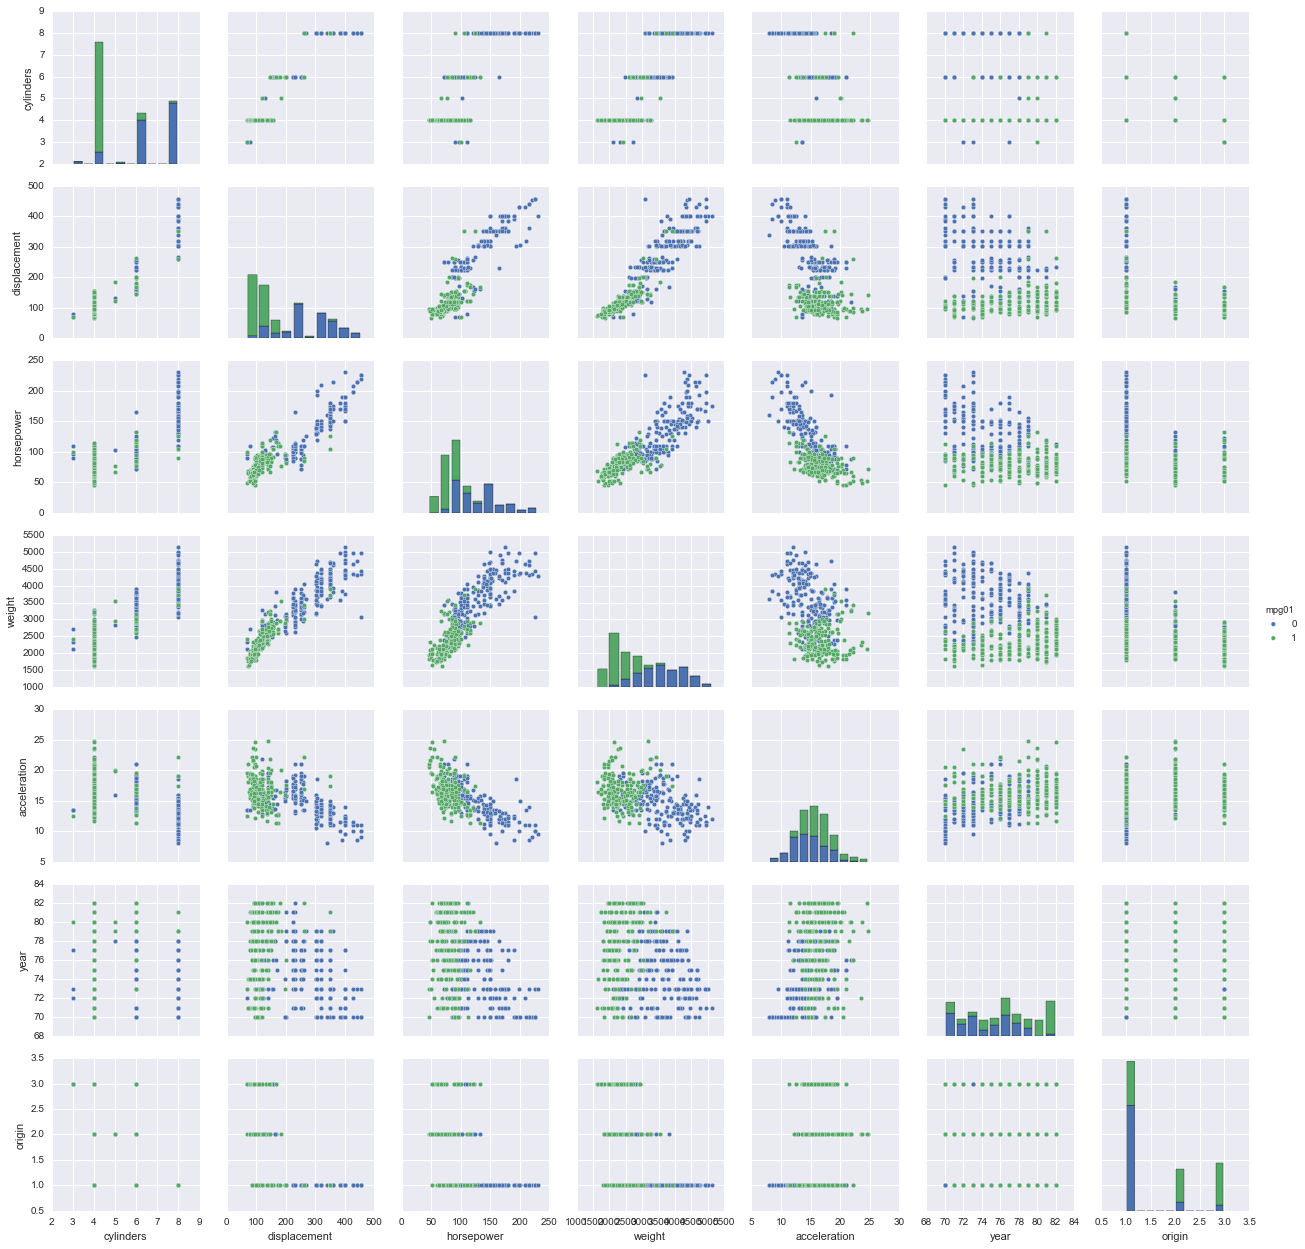

In [10]:
sns.pairplot(auto.drop("name", 1), hue="mpg01", size = 2.5,
             vars=(auto.columns.drop(["mpg01","name", "mpg"])))
plt.show()

From the graph above we can see that there are strong correlations.

- Weight, horsepower: positive
- Weight, displacement: positive
- horsepower, acceleration: negative

Note: **Engine displacemen**  is the swept volume of all the pistons inside the cylinders of a reciprocating engine in a single movement from top dead centre (TDC) to bottom dead centre (BDC)

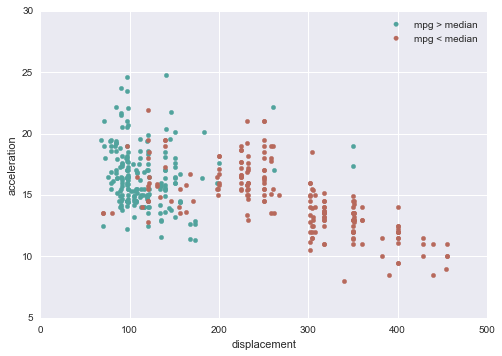

In [48]:
x1, y1 = auto.displacement[auto.mpg01 == 1], auto.acceleration[auto.mpg01 == 1]
x0, y0 = auto.displacement[auto.mpg01 == 0], auto.acceleration[auto.mpg01 == 0]

plt.scatter(x1, y1, color="#51A39D", label="mpg > median")
plt.scatter(x0, y0, color="#B7695C", label="mpg < median")
plt.xlabel("displacement")
plt.ylabel("acceleration")
plt.legend()
plt.show()

For ``displacement`` vis a vis ``acceleration`` it seems, at first sight, that there is a negative correlation between these two if the ``mpg`` < ``median mpg``, and almost no effect if ``mpg`` > ``median mpg``

In [45]:
x1.corr(y1)

-0.059462563235149035

In [47]:
x0.corr(y0)

-0.65654231862740275

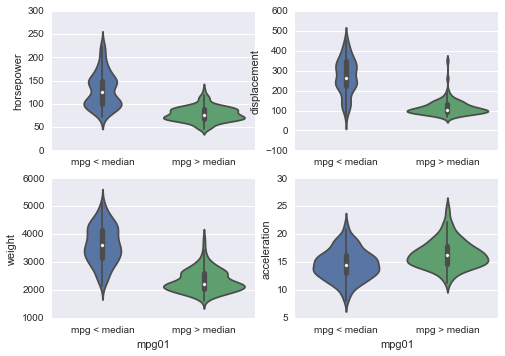

In [70]:
fig = plt.figure()
fig.add_subplot((221))
sns.violinplot(y="horsepower", x="mpg01", data=auto)
plt.xticks((0, 1), ("mpg < median", "mpg > median"))
plt.xlabel("")

fig.add_subplot(222)
sns.violinplot(y="displacement", x="mpg01", data=auto)
plt.xticks((0, 1), ("mpg < median", "mpg > median"))
plt.xlabel("")

fig.add_subplot(223)
sns.violinplot(y="weight", x="mpg01", data=auto)
plt.xticks((0, 1), ("mpg < median", "mpg > median"))

fig.add_subplot(224)
sns.violinplot(y="acceleration", x="mpg01", data=auto)
plt.xticks((0, 1), ("mpg < median", "mpg > median"))
plt.show()

With the latter Violin plots, we can see that the data, segregated by median ``mpg`` is divided in two apparent noticeable groups. While 

**3) Split the data into a training set and a test set.**

In [251]:
# We will remove mpg due the direct relationship with mpg01 
# which will be the binary variable to predict and name due its
# evident lack of information for this purpose

train_ix, test_ix = train_test_split(np.arange(len(auto)), test_size=0.20)
auto_train = auto.ix[train_ix].drop(["mpg", "name", "origin"], 1)
auto_test = auto.ix[test_ix].drop(["mpg", "name", "origin"], 1)

x_train, y_train = auto_train.drop("mpg01", 1), auto_train["mpg01"]
x_test,  y_test  = auto_test.drop("mpg01", 1), auto_test["mpg01"]

**4) Perform LDA on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in. What is the test error of the model obtained?**

We will start testing LDA on all the variables. This is only a first test

In [254]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)

test_error_lda = 1 - np.mean(lda.predict(x_test) == y_test)
print("Test Error LDA: {:.4%}".format(test_error))

Test Error LDA: 11.3924%


**5) Perform QDA on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in. What is the test error of the model obtained?**

In [281]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(x_train, y_train)

test_error_qda = 1 - np.mean(qda.predict(x_test) == y_test)
print("Test Error QDA: {:.4%}".format(test_error_qda))

Test Error QDA: 10.1266%


**6) Perform Logistic Regression on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in. What is the test error of the model obtained?**

In [282]:
log_reg = sm.GLM(y_train, x_train, family=sm.families.Binomial()).fit()

pred_vals = [1 if val > 0.5 else 0 for val in log_reg.predict(x_test)]
test_error_lg = 1 - np.mean(pred_vals == y_test)
print("Test Error Log. Regression: {:.4%}".format(test_error_lg))

Test Error Log. Regression: 13.9241%
